## BREAKING IMAGE CAPTCHA MODEL WITH CIFAR-10 Dataset

In [1]:
### Import various libraries ###
import tensorflow as tf 
import numpy as np
import graphviz
from keras.callbacks import ModelCheckpoint
import pydot
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Prepare and understand the data before creating the various models 

In [2]:
### Import CIFAR-10 Data ###
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

In [3]:
### Shape of the Training data ###
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
### Shape of the Test data ###
print(Y_train.shape)
print(Y_test.shape)

(50000, 1)
(10000, 1)


In [5]:
### Dimensionality of Y_train ###
Y_train[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [6]:
### Convert Y_train from a 2 dimensional to 1 dimensional array ###
Y_train = Y_train.reshape(-1,)
Y_train[:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3], dtype=uint8)

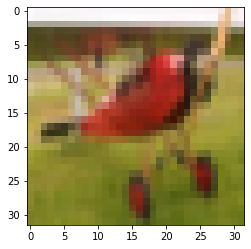

In [7]:
### Plot sample image ###
plt.imshow(X_train[35])

In [8]:
### Assign the classes with their actual names and not numbered labels ###
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

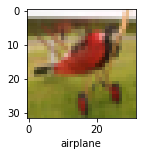

In [9]:
### Plot sample image again with the proper class label ###
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])
    
plot_sample(X_train,Y_train,35)

In [10]:
### Normalize data by dividing both X train test by 255 ###
X_train = X_train / 255.0
X_test = X_test / 255.0

### After normalizing the data, develop various models with different techniques 

#### Network 1 - Basic Model with no regularization technique or parameter tuning

In [37]:
network = models.Sequential([
        layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(3000, activation='relu', name="layer1"),
        layers.Dense(1000, activation='relu', name="layer2"),
        layers.Dense(10, activation='softmax', name="layer3")    
    ])

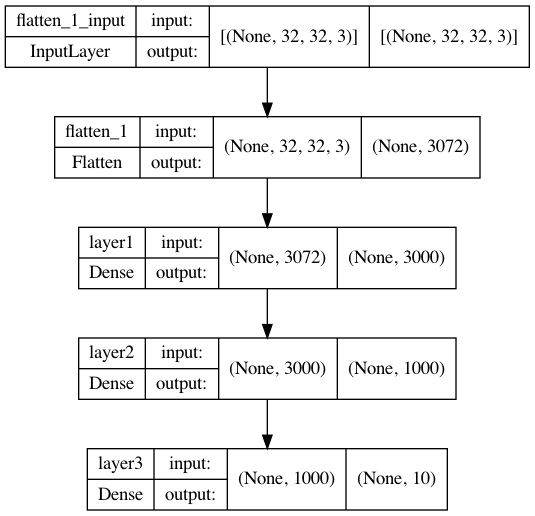

In [38]:
### Print network for viewing ###
plot_model(network, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
### Compile the network ###
network.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### Fitting the model with batch size of 128 and 15 training epochs ###
history = network.fit(X_train, 
                    Y_train, 
                    epochs=15,
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_test,Y_test))

Epoch 1/15
391/391 [==============================] - 22s 55ms/step - loss: 1.9647 - accuracy: 0.3139 - val_loss: 1.7696 - val_accuracy: 0.3598
Epoch 2/15
391/391 [==============================] - 23s 60ms/step - loss: 1.6652 - accuracy: 0.4026 - val_loss: 1.6123 - val_accuracy: 0.4201
Epoch 3/15
391/391 [==============================] - 21s 54ms/step - loss: 1.5777 - accuracy: 0.4391 - val_loss: 1.5442 - val_accuracy: 0.4452
Epoch 4/15
391/391 [==============================] - 21s 53ms/step - loss: 1.5034 - accuracy: 0.4628 - val_loss: 1.4785 - val_accuracy: 0.4753
Epoch 5/15
391/391 [==============================] - 23s 58ms/step - loss: 1.4682 - accuracy: 0.4757 - val_loss: 1.4962 - val_accuracy: 0.4755
Epoch 6/15
391/391 [==============================] - 23s 58ms/step - loss: 1.4215 - accuracy: 0.4922 - val_loss: 1.4497 - val_accuracy: 0.4827
Epoch 7/15
391/391 [==============================] - 25s 64ms/step - loss: 1.3862 - accuracy: 0.5082 - val_loss: 1.4194 - val_accuracy:

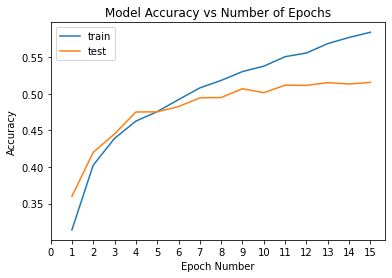

In [42]:
### Plot the comparison between training and test accuracy ###
plt.plot(range(1,1+len(history.history['accuracy'])), history.history['accuracy'])
plt.plot(range(1,1+len(history.history['val_accuracy'])), history.history['val_accuracy'])
plt.title('Model Accuracy vs Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,16,1))
plt.show()

In [63]:
### Training performance ###
## Find highest score for the test data ##
highest_score = max(history.history['val_accuracy'])

## Find the training epoch that has the highest test accuracy score 
epoch_num = np.array(history.history['val_accuracy']).argmax()+1

## Print the performance accuracy and training epoch
print((highest_score, epoch_num))

(0.5156999826431274, 15)


In [64]:
### Classification Report to compare the accuracy for all the classes ###
from sklearn.metrics import confusion_matrix , classification_report
y_pred = network.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(Y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.58      0.57      0.57      1000
           1       0.65      0.62      0.63      1000
           2       0.38      0.46      0.42      1000
           3       0.37      0.28      0.32      1000
           4       0.55      0.34      0.42      1000
           5       0.43      0.41      0.42      1000
           6       0.42      0.77      0.55      1000
           7       0.64      0.53      0.58      1000
           8       0.68      0.61      0.64      1000
           9       0.59      0.56      0.58      1000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.51     10000
weighted avg       0.53      0.52      0.51     10000



#### Network 2 - Include Dropout and Learning Rate 

In [11]:
### Setting the new learning rate ###
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

### Configuring new optimizer ###
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [12]:
network2 = models.Sequential([
        layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(3000, activation='relu', name="layer1"),
        layers.Dropout(0.2),
        layers.Dense(1000, activation='relu', name="layer2"),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax', name="layer3")    
    ])

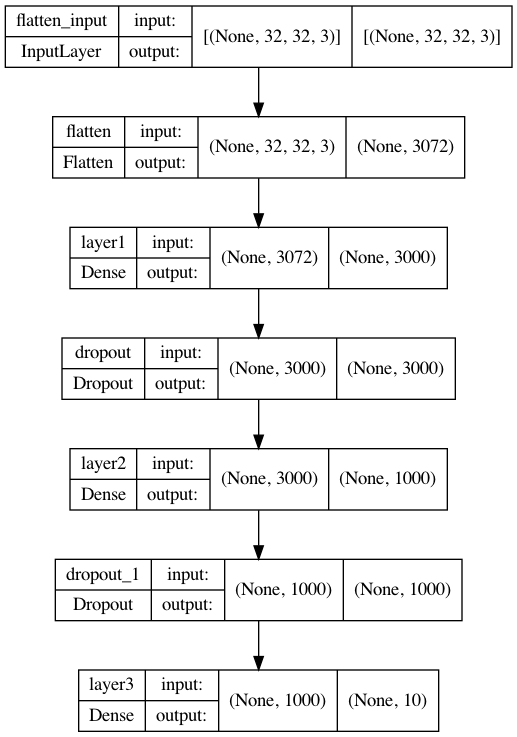

In [13]:
### Print network for viewing ###
plot_model(network2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
### Model Compilation ###
network2.compile(optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule),
             loss='sparse_categorical_crossentropy',
             metrics=["accuracy"])


### Fitting the model with batch size of 128 and 15 training epochs ###
history2 = network2.fit(X_train, 
                    Y_train, 
                    epochs=15,
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_test,Y_test))

Epoch 1/15
391/391 [==============================] - 40s 102ms/step - loss: 2.4994 - accuracy: 0.2468 - val_loss: 1.8400 - val_accuracy: 0.3301
Epoch 2/15
391/391 [==============================] - 40s 101ms/step - loss: 1.8507 - accuracy: 0.3364 - val_loss: 1.7582 - val_accuracy: 0.3788
Epoch 3/15
391/391 [==============================] - 41s 105ms/step - loss: 1.7628 - accuracy: 0.3702 - val_loss: 1.6865 - val_accuracy: 0.4201
Epoch 4/15
391/391 [==============================] - 45s 115ms/step - loss: 1.7153 - accuracy: 0.3893 - val_loss: 1.6356 - val_accuracy: 0.4149
Epoch 5/15
391/391 [==============================] - 43s 109ms/step - loss: 1.6700 - accuracy: 0.4058 - val_loss: 1.7021 - val_accuracy: 0.3931
Epoch 6/15
391/391 [==============================] - 43s 110ms/step - loss: 1.6383 - accuracy: 0.4171 - val_loss: 1.6484 - val_accuracy: 0.4066
Epoch 7/15
391/391 [==============================] - 44s 112ms/step - loss: 1.6146 - accuracy: 0.4233 - val_loss: 1.5628 - val_ac

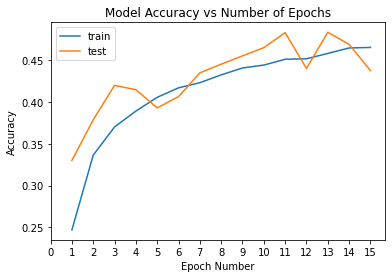

In [15]:
### Plot the comparison between training and test accuracy ###
plt.plot(range(1,1+len(history2.history['accuracy'])), history2.history['accuracy'])
plt.plot(range(1,1+len(history2.history['val_accuracy'])), history2.history['val_accuracy'])
plt.title('Model Accuracy vs Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,16,1))
plt.show()

In [16]:
### Training performance ###
## Find highest score for the test data ##
highest_score = max(history2.history['val_accuracy'])

## Find the training epoch that has the highest test accuracy score 
epoch_num = np.array(history2.history['val_accuracy']).argmax()+1

## Print the performance accuracy and training epoch
print((highest_score, epoch_num))

(0.4837999939918518, 13)


In [18]:
### Classification Report to compare the accuracy for all the classes ###
from sklearn.metrics import confusion_matrix , classification_report
y_pred2 = network2.predict(X_test)
y_pred_classes2 = [np.argmax(element) for element in y_pred2]

print("Classification Report: \n", classification_report(Y_test, y_pred_classes2))

Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.36      0.46      1000
           1       0.70      0.42      0.53      1000
           2       0.41      0.17      0.24      1000
           3       0.30      0.44      0.36      1000
           4       0.44      0.27      0.34      1000
           5       0.54      0.24      0.34      1000
           6       0.35      0.71      0.47      1000
           7       0.62      0.45      0.52      1000
           8       0.65      0.51      0.57      1000
           9       0.34      0.81      0.48      1000

    accuracy                           0.44     10000
   macro avg       0.50      0.44      0.43     10000
weighted avg       0.50      0.44      0.43     10000



#### Network 3 - Batch Normalization

In [19]:
network3 = models.Sequential([
        layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(3000, activation='relu', name="layer1"),
        layers.BatchNormalization(),
        layers.Dense(1000, activation='relu', name="layer2"),
        layers.BatchNormalization(),
        layers.Dense(10, activation='softmax', name="layer3")    
    ])

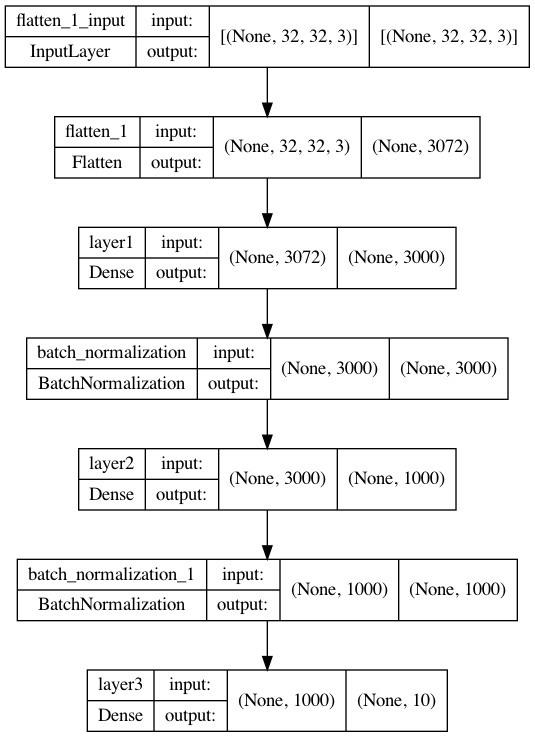

In [20]:
### Print network for viewing ###
plot_model(network3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
### Model Compilation ###
network3.compile(optimizer = 'adam',
             loss='sparse_categorical_crossentropy',
             metrics=["accuracy"])


### Fitting the model with batch size of 128 and 15 training epochs ###
history3 = network3.fit(X_train, 
                    Y_train, 
                    epochs=15,
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_test,Y_test))

Epoch 1/15
391/391 [==============================] - 34s 85ms/step - loss: 1.7981 - accuracy: 0.3748 - val_loss: 1.8209 - val_accuracy: 0.3691
Epoch 2/15
391/391 [==============================] - 31s 79ms/step - loss: 1.6370 - accuracy: 0.4231 - val_loss: 1.8345 - val_accuracy: 0.3576
Epoch 3/15
391/391 [==============================] - 30s 76ms/step - loss: 1.5684 - accuracy: 0.4469 - val_loss: 1.9881 - val_accuracy: 0.3336
Epoch 4/15
391/391 [==============================] - 30s 77ms/step - loss: 1.5107 - accuracy: 0.4675 - val_loss: 1.8180 - val_accuracy: 0.3843
Epoch 5/15
391/391 [==============================] - 31s 78ms/step - loss: 1.4676 - accuracy: 0.4807 - val_loss: 1.7894 - val_accuracy: 0.3974
Epoch 6/15
391/391 [==============================] - 35s 88ms/step - loss: 1.4228 - accuracy: 0.4981 - val_loss: 1.9026 - val_accuracy: 0.3729
Epoch 7/15
391/391 [==============================] - 33s 83ms/step - loss: 1.3815 - accuracy: 0.5127 - val_loss: 1.9004 - val_accuracy:

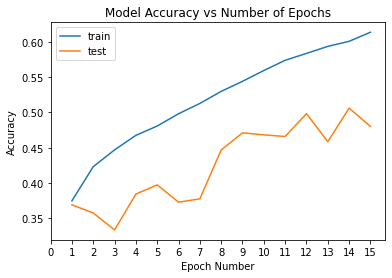

In [22]:
### Plot the comparison between training and test accuracy ###
plt.plot(range(1,1+len(history3.history['accuracy'])), history3.history['accuracy'])
plt.plot(range(1,1+len(history3.history['val_accuracy'])), history3.history['val_accuracy'])
plt.title('Model Accuracy vs Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,16,1))
plt.show()

In [23]:
### Training performance ###
## Find highest score for the test data ##
highest_score = max(history3.history['val_accuracy'])

## Find the training epoch that has the highest test accuracy score 
epoch_num = np.array(history3.history['val_accuracy']).argmax()+1

## Print the performance accuracy and training epoch
print((highest_score, epoch_num))

(0.5060999989509583, 14)


In [24]:
### Classification Report to compare the accuracy for all the classes ###
from sklearn.metrics import confusion_matrix , classification_report
y_pred3 = network3.predict(X_test)
y_pred_classes3 = [np.argmax(element) for element in y_pred3]

print("Classification Report: \n", classification_report(Y_test, y_pred_classes3))

Classification Report: 
               precision    recall  f1-score   support

           0       0.47      0.72      0.57      1000
           1       0.75      0.46      0.57      1000
           2       0.32      0.45      0.38      1000
           3       0.30      0.34      0.32      1000
           4       0.42      0.33      0.37      1000
           5       0.38      0.50      0.44      1000
           6       0.61      0.45      0.52      1000
           7       0.57      0.55      0.56      1000
           8       0.70      0.50      0.58      1000
           9       0.61      0.50      0.55      1000

    accuracy                           0.48     10000
   macro avg       0.51      0.48      0.48     10000
weighted avg       0.51      0.48      0.48     10000

